**AOS204C - Machine Learning for the Physical Sciences**

**Final Project**

Name: Jean Helder Marques Ribeiro

UCLAID: 805275429



**Loading the data**

In this part I have to load the data for google collab. The data is stored in binary  format in the cell center of an unstructured grid. 

There is an specific way of writing the files index from the CharLES solver that I had to copy from the source code and translate to python, it is the 'readbinfiles' function.

The data is stored in a way that each row is a cell index and each column is a snapshot.

In [1]:
# Load Libraries
from google.colab import drive
import os
import numpy as np

from scipy.interpolate import griddata

import matplotlib.pyplot as plt
from matplotlib import cm

import time

start_time = time.time()

initFile = 2000
endFile  = 600000

noiseLvl = 0.01   # amount of noise you want to add to the spatial data
                  # 0.05 is probably alreay too much

# Load Data
drive.mount('/content/drive')

def readbinfiles(varname,idx):
  # is this strange? yes. But this is the way CharLES does it, so I'll keep it like that
  if (idx >= 10000000):
      filename = '%s.%08d.dat' % (varname,idx)
  elif (idx >= 1000000):
      filename = '%s.%07d.dat' % (varname,idx)
  else:
      filename = '%s.%06d.dat' % (varname,idx)

  qread      = np.fromfile(filename, np.float64)
  return qread

def loadData(files,vol):
  ncv = vol.shape[0]            # number of control volumes
  T   = files.shape[0]          # number of snapshots

  # Load files
  q = np.zeros((ncv,T),dtype=np.float64)
  ii = 0
  # Here I load all data I want according to the variable 'files'
  # I stack them by the control volume index and a column for each snapshot
  for idx in files:
    q[:,ii] = readbinfiles('/content/drive/MyDrive/AOS111/vz',idx)
    ii += 1 

  return q

# array of files to read
files = np.arange(initFile,endFile,initFile)

# Cell center location and volume
vol   = np.fromfile('/content/drive/MyDrive/AOS111/cellVolume.dat', np.float64)
x_cv  = np.fromfile('/content/drive/MyDrive/AOS111/cellCentroid.dat', np.float64)
ncv   = vol.shape[0]                        # number of control volumes
x_cv  = np.reshape(x_cv,(ncv,3))            # x,y,z CV location
T = files.shape[0]          # number of snapshots

#q = loadData(files,vol)

Mounted at /content/drive


**Auxiliary functions**

There are some functions that help dealing with plotting specifically. In the project proposal I have mentioned CGNS Library, but I could not find a way to couple a library I created in google collab, so I am plotting in a (also fancy) way using meshgrid.


My idea is simple, I use 'plotContour' function to interpolate the unstructured data to a structured grid and create an artificial airfoil with 'genAirfoil' (yes, I calculate the NACA geometry with the correct equations) and fill it to generate the airfoil geometry at the specified angle of attack (26 degrees).

There are some tricks here and there, but this part of the code is pretty easy to follow.

In [2]:
# Airfoil geometry
def genAirfoil(aoa):
  # Generate wing geometry file:
  NACA   = 15             # Chord Thickness (NACA00??)
  points = 1001              # Number of points on the airfoil
  dx     = 1.0/(points-1)
  j = 0
  x0 = np.arange(0,1,dx) 
  y0 = np.zeros(x0.shape)
  dummy = np.arange(x0.shape[0])
  for j in dummy:
      xi    = x0[j]/1.0 
      y0[j] = 5.0 *NACA/100 *( + 0.29690*xi**0.5 
                            - 0.12600*xi**1 
                            - 0.35160*xi**2 
                            + 0.28430*xi**3 
                            - 0.10360*xi**4 )

  x0 = x0-1
  Alpha = -aoa
  Xact  = [] 
  Yact  = [] 

  xrt = np.zeros(x0.shape)
  yrt = np.zeros(x0.shape)
  xrb = np.zeros(x0.shape)
  yrb = np.zeros(x0.shape)
  dummy = np.arange(j) # I had to create this dummy for loops because for some reason only God knows, ipython was collapsing with range(j)
  for i in dummy:
      xrt[i] =  + x0[i]
      yrt[i] =  + y0[i]
      
      if (np.abs(xrt[i] + 0.917) <= 0.01):
          Xact.append(xrt[i]) 
          Yact.append(yrt[i]) 
      
      xrb[i] =  + x0[i]
      yrb[i] =  - y0[i]

  XA  = np.concatenate((xrt,xrb), axis=0) 
  YA  = np.concatenate((yrt,yrb), axis=0)

  XA  = np.concatenate((XA,XA), axis=0) 
  YA  = np.concatenate((YA,YA), axis=0)

  XA = XA + 1

  dummy = np.arange(XA.shape[0])
  for ino in dummy:
      dummyx = XA[ino]*np.cos(np.deg2rad(Alpha)) - YA[ino]*np.sin(np.deg2rad(Alpha))
      dummyy = XA[ino]*np.sin(np.deg2rad(Alpha)) + YA[ino]*np.cos(np.deg2rad(Alpha))
      XA[ino] = dummyx 
      YA[ino] = dummyy

  return XA,YA

# Plot the airfoil geometry on top of the contour
def plotAirfoil(aoa):
  XA,YA = genAirfoil(26)
  plt.fill(XA, YA, color='gray', alpha=0.5)
  plt.plot(XA, YA, color='black', linewidth=1.5)

# Plot field contour
def plotContour(xmin,xmax,ymin,ymax,maxrange,x_cv,q):
  X = x_cv[:,0]
  Y = x_cv[:,1]

  # Generate structured mesh for interpolation
  dx = 0.05
  dy = 0.05
  xm = np.arange(xmin,xmax,dx)
  ym = np.arange(ymin,ymax,dy)
  XG, YG = np.meshgrid(xm, ym, sparse=False, indexing='ij')

  # Interpolation onto structured grid
  Vz_Interp = griddata((X,Y), q, (XG, YG), method='cubic')

  # Plot vorticity-Z contour field
  range = np.arange(-maxrange,0,0.05) # I am skipping ZERO as a contour level because it looks uglier
  range = np.concatenate((range,np.flipud(-range)))
  plt.contour(XG,YG,Vz_Interp,range,cmap='bwr')
  plt.clim(-0.5*maxrange, 0.5*maxrange)
  plt.colorbar()
  
  # Plot airfoil on top
  plotAirfoil(26)


**Load flow field**

Here import the flow field and generate a visualization of the LAST snapshot ('tidx').

I also remove the mean and set the variable 'noiseLevel' which will be used to artificially add spatial noise to the data

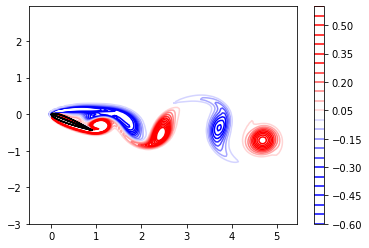

In [3]:
# The flow field 
tidx = T-1 # select snapshot to plot, this way it is plotting the LAST snapshot

# Reading data
qr = loadData(files,vol)

# Removing mean flow
q  = np.zeros((ncv,T),dtype=np.float64) 
qm = np.mean(qr,axis=1) 
for i in range(T):
  q[:,i] = qr[:,i] - qm

# Specify how much noise you want
maxrange   = np.amax(np.abs(q))
noiseLevel = noiseLvl*maxrange

# Plot vorticity-Z contour field
plotContour(-0.5,5.5,-3,3,0.6,x_cv,qr[:,tidx]) 

**Noise added**

This part only runs if we want to add noise.

Noise is a random uncorrelated spatial information that is very common in experimental data.

See that we can still see the flowfield, but we can probably do better than that.

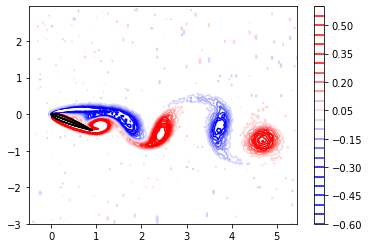

In [4]:
if noiseLevel > 0:
  ii = 0
  for idx in files:
    noise     = noiseLevel*np.random.randn(ncv,)
    q[:,ii]  += noise
    ii += 1 

  # Plot vorticity-Z contour field WITH NOISE
  plotContour(-0.5,5.5,-3,3,0.6,x_cv,q[:,tidx]+qm) 

**Weight matrices**

Ok, this part is more mathematical, we need to weight the data by their cell volume. The covariance matrix is computed from an integral of the data covariance, so we need the cell volume to perform this Riemann sum correctly.

I am doing 

$X^T W X =  \Lambda V$

which is an eigenvalue problem with $\Lambda^2 = \Sigma$, the matrix of principal values. That is equal to performing the SVD (singular value decomposition) on

$ W^{1/2} X = U \Sigma V^*$

that's why I use $W^{1/2}$ as a weighting matrix. And I think SVD directly is easier as I already get the $U$ singular vectors. In case we have very large data sets that would not be a good idea though, but for the present data, it is ok.


In [5]:
# Applying weigths as cell volumes are not equal
ii = 0
for idx in files:
    q[:,ii] = q[:,ii]*np.sqrt(vol)     # This weighting has to be applied because cell volume is not the same for all
    ii += 1 


**Singular Value Decomposition**

This one builds the covariance matrix and performs SVD on it.

I use SVD even if it is an eigenvalue problem because the SVD algorithm in numpy is more robust than the eigenvalue one (based on QR algorithms).

There is a code for spectral filtering of the covariance matrix which is good to clean up the modes but not for cleaning the noise in reconstruction. As this is the ultimate goal, I do not use it, but I left it there.


In [6]:
# Performing Principle Component Analysis

# spectral filtering of covaraince matrix
def pca_filter(C,Nfilt):
    T     = C.shape[0]
    Cbar  = np.zeros((T,T))
    # Gaussian function
    f = np.exp(-np.linspace(-2.285,2.285,2*Nfilt+1)**2) 
    f = f/np.sum(f)
    if (Nfilt > 0):
      C = np.concatenate((C,C),axis=0)
      C = np.concatenate((C,C),axis=1)
      for i in range(T):
          for j in range(T):
              dummy = 0.
              for k in range(-Nfilt,Nfilt+1):
                  dummy += C[i+k,j+k]*f[k+Nfilt] 
              Cbar[i,j] = dummy
    else:
        Cbar = C
    return Cbar

# Compute covariance matrix
C = q.T@q

Nfilt = 0 #T//4
if (Nfilt != 0):
  C = pca_filter(C,Nfilt)

u,s,v = np.linalg.svd(C)
s = np.sqrt(s)
u = q@u@np.diag(1/s)

**Principal components covergence**

Here I evaluate the convergence of the singular values to see the smallest dimension where I can recover the original data.

Depending on how much noise you add, the singular values may decay very slowly, which means that there is too much noise in the data.

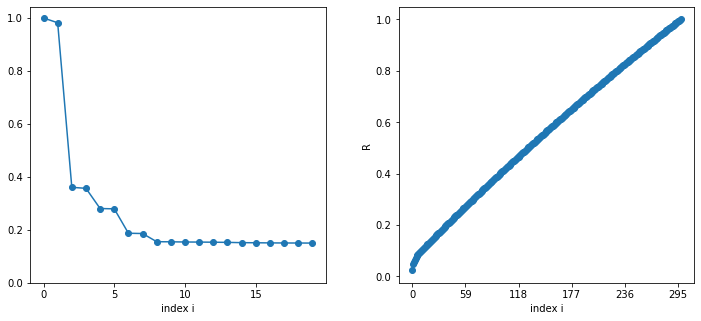

In [7]:
# Evaluating convergence of the principal components
smax = np.amax(s)
ssum = np.zeros((T,))
for i in range(T):
  for j in range(i+1):
    ssum[i] += s[j]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout()
ax1.plot(np.arange(0,20,1),s[0:20]/smax,marker='o')
ax1.set_xticks(np.arange(0,20,5))
ax1.set_yticks(np.arange(0,1.1,0.2))
ax1.set_xlabel('index i')
#ax1.set_ylabel('Principal value normalized')
ax2.plot(np.arange(0,T,1),ssum[0:T]/np.sum(s),marker='o')
ax2.set_xticks(np.arange(0,T,T//5))
ax2.set_yticks(np.arange(0,1.1,0.2))
ax2.set_xlabel('index i')
ax2.set_ylabel('R')
fig.set_size_inches(10.5, 4.5)
plt.show()
plt.show()

**Pricipal component modes**

You can specify with $U$ mode you want to visualize here.

The modes are usually good to reveal physical mechanisms of the flow field, here we see that it kind of clusters regions where the vortices are observed.

ACHTUNG: I had problems with plotting the modes when I have too much noise, the data is ok, but it seems that it is a problem with my 'plotContour' function which I could not understand.

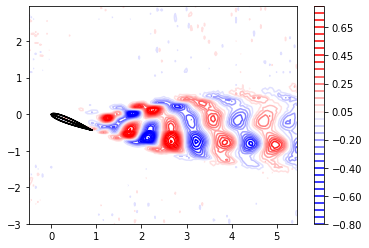

In [14]:
# Plot principal vectors
iidx = 2
vec = np.real(u[:,iidx])/(np.amax(np.abs(u[:,iidx])))
plotContour(-0.5,5.5,-3,3,0.8,x_cv,vec) 

**Oscillators**

Although it was not mentioned in class, when we do eigendecomposition or SVD we obtain

$ W^{1/2} X = U \Sigma V^*$

the $V$ vectors can reveal very interesting things. For instance, if we consider the modes that are paired in the $\Sigma$ spectrum as dynamic oscillators 

$a_0 + ja_1$

We can plot them in the complex plane as

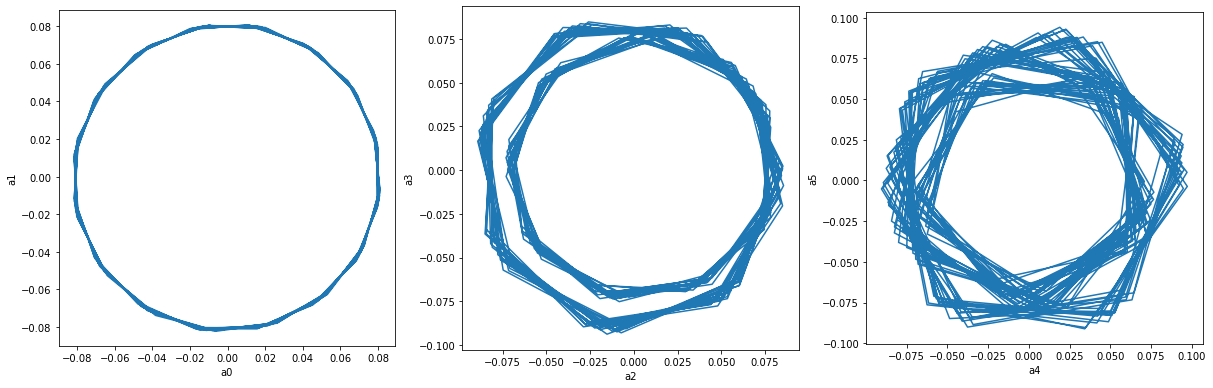

In [9]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
ax1.plot(v[0,:],v[1,:])
ax1.set_xlabel('a0')
ax1.set_ylabel('a1')
ax1.set_aspect('equal')
ax2.plot(v[2,:],v[3,:])
ax2.set_xlabel('a2')
ax2.set_ylabel('a3')
ax2.set_aspect('equal')
ax3.plot(v[4,:],v[5,:])
ax3.set_xlabel('a4')
ax3.set_ylabel('a5')
ax3.set_aspect('equal')
fig.set_size_inches(20.5, 30.5)
plt.show()

**Frequency of modes**

First thing we notice is that frequencies are different for the mode pairs, right?

but also, we see that these pair have a good correlation. Let's see which frequnecies they contain.

The x-axis is the Fage-Johanssen Strouhal number defined as

$St = \frac{\omega}{2\pi}\frac{L_c \sin \alpha}{U_\infty}$

And it is known that the vortex shedding frequency for laminar flows with this $St$ definition falls between $0.1 \le St \le 0.2$, exactly where we see the dominant mode pair to oscillate. The $2$nd and $3$rd mdoe pairs are seen as harmonics, they have spectral content in the harmonic frequencies.

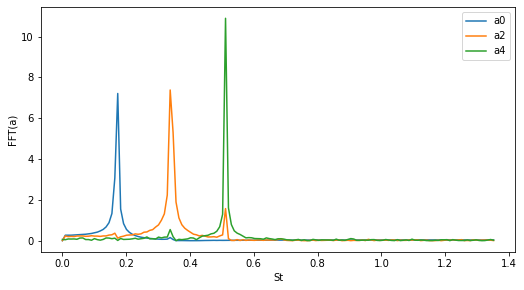

In [10]:
from numpy.fft import fft
VV = fft(v,axis=1)
tt = endFile*0.0008
df = 1/tt
ff = np.arange(0,(T/2-1)*df,df)

ff = ff*np.sin(np.deg2rad(26))/(0.1)
VV = np.abs(np.real(VV))

fig = plt.gcf()
plt.plot(ff,VV[0,0:(T//2)], label='a0')
plt.plot(ff,VV[2,0:(T//2)], label='a2')
plt.plot(ff,VV[4,0:(T//2)], label='a4')
plt.ylabel('FFT(a)')
plt.xlabel('St')
plt.legend()
fig.set_size_inches(8.5, 4.5)
plt.show()

**Reconstruction**

Here we see the reconstruction of the flow field with the small number of 'k' principal components to show how we can reduce the dimensionality of the flow data and even remove background noise.

 Energy sum percent: 9.87 



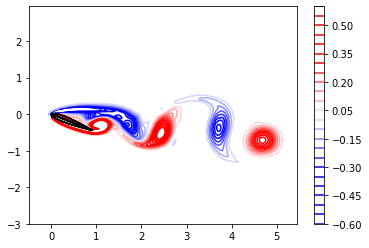

In [11]:
# Flow field reconstruction
k = 10            # reduced dimension 
print(' Energy sum percent: %.2f \n' % (ssum[k]*100/ssum[-1]))

ss = np.diag(s)
qrec = u[:,:k]@ss[:k,:k]@v[:k,:]

for i in range(T):
  qrec[:,i] = qm + qrec[:,i]*(1/np.sqrt(vol))

# Plot vorticity-Z contour field RECONSTRUCTION
plotContour(-0.5,5.5,-3,3,0.6,x_cv,qrec[:,tidx]) 

In [12]:
end_time = time.time()
print('\n JOB FINISHED \n')
print(' Total time: %.2f \n' % (end_time - start_time))


 JOB FINISHED 

 Total time: 368.20 



In [13]:
print(s.shape)

(299,)
